In [5]:
# Source: https://learn.microsoft.com/en-us/azure/cognitive-services/openai/tutorials/embeddings?tabs=command-line

![](images/doc-clustering-and-theme-generation.jpg)

# Overview  
Working with embeddings and summarizatoin, to find clusters of similar documents and their corresponding themes.  
* Download CNN daily news dataset  
* Generate embeddings for each document (using OpenAI)
* Find clusters of similar documents (Kmeans/sklearn)
* Generate a short summary of each document (OpenAI)
* Generate themes across each cluster of documents (OpenAI)

In [6]:
#Install open source datasets library from HuggingFace
# !pip install datasets

SyntaxError: invalid syntax (2555534135.py, line 2)

In [10]:
# Load CNN daily news dataset
from datasets import load_dataset


dataset = load_dataset('cnn_dailymail', '3.0.0', split="train[:10%]")
# source: https://huggingface.co/datasets/cnn_dailymail

# Dataset description
''' The CNN / DailyMail Dataset is an English-language dataset containing just over 300k unique news articles as
written by journalists at CNN and the Daily Mail. The current version supports both extractive and abstractive
summarization, though the original version was created for machine reading and comprehension and abstractive 
question answering. '''

Found cached dataset cnn_dailymail (/home/azureuser/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


' The CNN / DailyMail Dataset is an English-language dataset containing just over 300k unique news articles as\nwritten by journalists at CNN and the Daily Mail. The current version supports both extractive and abstractive\nsummarization, though the original version was created for machine reading and comprehension and abstractive \nquestion answering. '

In [10]:
# dataset highlights
dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 28711
})

In [11]:
df = dataset.to_pandas().head(5000) # convert to pandas dataframe
df = df[['article']]                # subset to "article" column
df.head()

,article
0,"LONDON, England (Reuters) -- Harry Potter star..."
1,Editor's note: In our Behind the Scenes series...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we..."
3,WASHINGTON (CNN) -- Doctors removed five small...
4,(CNN) -- The National Football League has ind...


## Create embeddings
### Install Open AI library and import helper libraries

In [12]:
#Install OpenAI library
pip install openai

Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity

openai.api_type = "azure"
openai.api_base = os.getenv('OPENAI_API_ENDPOINT') 
openai.api_version = "2022-12-01"
openai.api_key = os.getenv("OPENAI_API_KEY")

### Set your deployment model
This model should be deployed in your OpenAI deployments. A "text-search-xxx-doc" model will be leveraged for generating document embeddings, for querying against. These models help measure whether long documents are relevant to a short search query. There are two input types supported by this family: "doc", for embedding the documents to be retrieved, and "query", for embedding the search query. 

**Model taxonomy**: {family} - {capability} - {input-type} - {identifier}  

{family}     --> text-search   (general text GPT-3 model)  
{capability} --> babbage  (curie is second most powerful in ada-babbage-curie-davinci family)  
{input-type} --> doc    (for embedding the documents to be retrieved)  
{identifier} --> 001    (version 001)  

model = 'text-search-babbage-doc-001'

In [13]:
deployment_model = 'text-search-babbage-doc-001'

In [15]:
# For demo - Limit api calls.
mini_df = df.head(100)

In [17]:
mini_df.article

0     LONDON, England (Reuters) -- Harry Potter star...
1     Editor's note: In our Behind the Scenes series...
2     MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...
3     WASHINGTON (CNN) -- Doctors removed five small...
4     (CNN)  -- The National Football League has ind...
                            ...                        
75    (CNN) -- The owner of a North Carolina beach h...
76    LONDON, England (CNN) -- The head of Britain's...
77    SAN DIEGO, California (CNN) -- You must know w...
78    ROME, Italy -- Mauro Camoranesi scored with 13...
79    (CNN)  -- One Australian soldier, three civili...
Name: article, Length: 80, dtype: object

In [16]:
# limit size
max_size = 2048
mini_df['article'] = mini_df['article'].str.split(n=max_size).str[:max_size].str.join(' ')
print(mini_df['article'].head(1))

0    LONDON, England (Reuters) -- Harry Potter star...
Name: article, dtype: object


## Compute embeddings for each article calling an OpenAI embeddings model
#### This api call can take a significant time to process

In [51]:
mini_df['babbage_search'] = mini_df["article"].apply(lambda x : get_embedding(x, engine = deployment_model))

In [50]:
# Inspect embeddings. There should be an embeddings vector for each document
print("doc embedding length: ", len(mini_df['babbage_search'].iloc[0]), "\n")
mini_df['babbage_search']

0     [-0.019866133108735085, 0.018403055146336555, ...
1     [-0.017632996663451195, 0.015490160323679447, ...
2     [-0.02926699072122574, 0.030972033739089966, -...
3     [-0.03963899612426758, 0.018653646111488342, -...
4     [-0.03304106369614601, -0.006709795445203781, ...
                            ...                        
95    [-0.016215438023209572, 0.011788046918809414, ...
96    [-0.009694568812847137, 0.02125215157866478, 0...
97    [-0.02659847028553486, 0.008203140459954739, 0...
98    [-0.00768100144341588, 0.004722259938716888, 0...
99    [-0.019009996205568314, 0.018992343917489052, ...
Name: babbage_search, Length: 100, dtype: object

# Considering Chunking Texts for limiting doc input size  
To learn more about embeddings, check out the [Learn more about OpenAI embeddings](https://beta.openai.com/docs/guides/embeddings)   

https://github.com/openai/openai-cookbook/blob/main/examples/Embedding_long_inputs.ipynb

## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [ ]:
# imports
import numpy as np

# load data
# mini_df["babbage_search"] = mini_df.babbage_search.apply(eval).apply(np.array)  # convert string to numpy array if initial dataframe construction interpreted embeddings as type string/object
matrix = np.vstack(mini_df.babbage_search.values)
matrix.shape

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.  

While scikit-learn is used in this example, further reference on K-means clustering, and quick deployment within Azure Machine Learning, can be found at [https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/k-means-clustering]

In [63]:
#Cluster the articles into several (n_clusters) clusters, and then save those cluster labels as new column in our mini_df dataframe (called "Cluster")
from sklearn.cluster import KMeans

n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
mini_df["Cluster"] = labels

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## TSNE is very popular for visualizing high dimensional data

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

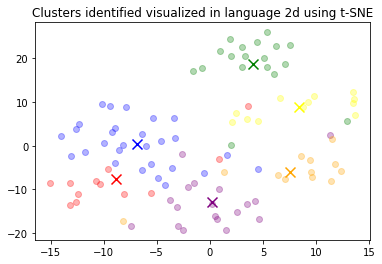

In [64]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=25, init="random", learning_rate=10)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow","orange"]):
    xs = np.array(x)[mini_df.Cluster == category]
    ys = np.array(y)[mini_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

### Generate overall summary for each article
One of the great aspects of the cnn daily news dataset are the corresponding highlights / summary of each artcile. For this lab, we'll instead use OpenAI to generate a summary for each, for inspecting each cluster


In [1]:
def summarize_text(text):   
    '''helper function for submitting summarization api calls'''
    model  = "text-curie-001"
    prompt = text + "\n\n tl;dr"

    response = openai.Completion.create(
        engine=model,
        prompt=prompt,
        temperature=0.7,
        max_tokens=60,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None)

    return(response['choices'][0]['text'])

Bad pipe message: %s [b'\xac\xdc\xdcl(\xf6\xaf\x8d\xbf\r0\xfd\xbdC\x88\x18H\xc9 \x82x\x17\xfd\xd2\xf9\xb9\xfd\x10\x83\xd1\xef', b'\x8b\x1f\x95e\xb3\x96\xf3\xfe\xf1>\xf8\x89\xc3\x12H\x16\x7fy\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-']
Bad pipe message: %s [b'9p $\x97I\xa9\x10A\x06d~\x03\xfa\xa7E\xcd\x85 +G\xd8\x03\x98\xa4\x1a|\xd3\x11\xffspr\xdcO0\xea\x8aj\x88\x1e\xcc=i\xb9\x86\xfa\xcdvP\xa7\x00\x08\x13\x02\x13\x03']
Bad pipe message: %s [b'\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127', b'.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x

## Summarize each article!  
This will allow quick comparison of articles within each cluster

In [66]:
mini_df['summary'] = mini_df['article'].apply(lambda x: summarize_text(x))

In [67]:
#clean up and inspect summary results
mini_df['summary'] = mini_df['summary'].str.replace("\n\n","")
mini_df['summary']

0     : 18-year-old Daniel Radcliffe has a reported ...
1     : Miami-Dade County's ninth floor is home to i...
2     : Survivors tell harrowing tales of survival a...
3     :Doctors removed five polyps from President Bu...
4      Vick has been indefinitely suspended from the...
                            ...                        
95    :Witnesses in Colorado are at risk of intimida...
96     Newly unseen footage of Diana, Princess of Wa...
97    : Retired Lt. Gen. Ricardo Sanchez criticized ...
98    :The Republicans had a free-for-all Wednesday ...
99    :Marine general says 1,000 detainees freed in ...
Name: summary, Length: 100, dtype: object

How well did the summarization work? Let's view a single article, and the corresponding summary

In [68]:
print(mini_df['article'].iloc[0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [174]:
print(mini_df['summary'].iloc[0])

:

Daniel Radcliffe is an 18-year-old actor and he is worth an estimated $41.1 million. He doesn't plan to spend his money on fast cars or wild parties, but he does plan to spend his money on books and CDs.


### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use davinci to name the clusters, based on a random sample of 4 reviews from that cluster.

In [69]:
# model used for summarizing 4 articles within each cluster
deployment_model_for_summarization = 'text-davinci-002'

For each cluster of articles:  
. . . .collect a sample of articles  
. . . .prompt OpenAI model to find what each of those articles have in common <-- these becomes the cluster **"theme"**  
. . . .print: cluster theme, summary of sample articles (how well did OpenAI model perform?)


In [70]:
# Reading a review which belong to each group.
article_per_cluster = 4

for i in range(n_clusters):
    '''For each cluster, take a sample of articles, generate a common theme across, and print theme & samples'''
    print(f"Cluster {i} Theme:", end=" ")

    articles = "\n".join(
        mini_df[mini_df.Cluster == i]
        .summary
        .str.replace("\n\n", ":  ")
        .sample(article_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine=deployment_model_for_summarization,
        prompt=f'What do the following articles have in common?\n\narticless:\n"""\n{articles}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = mini_df[mini_df.Cluster == i].sample(article_per_cluster, random_state=42)
    for j in range(article_per_cluster):
        print(str(i), end=",")
        print(sample_cluster_rows.summary.values[j][:70], end=":   ")
        print(sample_cluster_rows.article.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme:  Natural disasters
0,: Survivors tell harrowing tales of survival after the Minneapolis bri:   MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis br
0,: A magnitude 4.2 earthquake shook the San Francisco area Friday morni:   SAN FRANCISCO, California (CNN) -- A magnitude 4.2 earthquake shook th
0,:More than 100 homes in an upscale San Diego community were evacuated :   SAN DIEGO, California (CNN) -- More than 100 homes in an upscale San D
0,:A contestant in Nigeria's "Gulder Ultimate Search" show has drowned, :   LAGOS, Nigeria (Reuters) -- Nigeria's television survival show has bee
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: The theme of these articles is money.
1,: 18-year-old Daniel Radcliffe has a reported £20 million ($41.1 milli:   LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains 
1, Werder Bremen has signed Carlos Alberto from Fluminense for a club re: